In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [2]:
from helper import *

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 17

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


In [3]:
# RGB to HSV Network
class RGBtoHSVNet(nn.Module):
    def __init__(self):
        super(RGBtoHSVNet, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# RGB-HSV Dataset
rgb_train = generate_rgb_samples(1000, device=device, seed=42)
hsv_train = rgb_to_hsv(rgb_train)

rgb_test = generate_rgb_samples(250, device=device, seed=123)
hsv_test = rgb_to_hsv(rgb_test)

rgb_train_loader = DataLoader(TensorDataset(rgb_train.cpu(), hsv_train.cpu()), batch_size=32, shuffle=False)
rgb_test_loader = DataLoader(TensorDataset(rgb_test.cpu(), hsv_test.cpu()), batch_size=32, shuffle=False)

# Example usage (deterministic training):
rgb_model = RGBtoHSVNet()
rgb_criterion = nn.MSELoss()
rgb_optimizer = optim.Adam(rgb_model.parameters(), lr=0.001)
rgb_losses, trained_rgb = train_model(rgb_model, rgb_train_loader, rgb_criterion, rgb_optimizer, num_epochs=100, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda
Epoch [20/100], Loss: 0.005751
Epoch [40/100], Loss: 0.002921
Epoch [60/100], Loss: 0.001910
Epoch [80/100], Loss: 0.001440
Epoch [100/100], Loss: 0.001160


In [5]:
# Show specific samples:
show_rgb_hsv_samples(rgb_test.cpu(), hsv_test.cpu(), indices=0)  # Single index

RGB to HSV Conversion Samples:
------------------------------------------------------------
Index  RGB                  HSV                 
------------------------------------------------------------
0      (0.067, 0.945, 0.221) (0.363, 0.929, 0.945)


In [6]:
# RGB
index = 0
predictions_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)
print(f"\nMSE Loss: {nn.MSELoss()(predictions_rgb, sample_targets_rgb).item():.8f}")

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
0      (0.067, 0.945, 0.221) (0.363, 0.929, 0.945) (0.364, 0.921, 0.937)

MSE Loss: 0.00004530


In [7]:
# Full Network capture
rgb_inputs, rgb_activations, rgb_outputs = get_activations(trained_rgb, rgb_train_loader, dataset_type='rgb_hsv')

# Single Sample capture
single_rgb_inputs, single_rgb_activations, single_rgb_outputs = get_activations(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

In [8]:
# Finding KNN - L2
indices_rgb, distances_rgb = find_knn(rgb_activations, single_rgb_activations, k=1, metric='l2')
print(f"KNN Indices (L2): {indices_rgb}")
print(f"KNN Distances (L2): {distances_rgb}")

KNN Indices (L2): tensor([640])
KNN Distances (L2): tensor([0.2345])


In [9]:
filtered_rgb_loader, filtered_size = create_filtered_dataloader(rgb_train_loader, exclude_indices=indices_rgb, batch_size=64, shuffle=False)

In [10]:
filtered_rgb_model = RGBtoHSVNet()
rgb_criterion = nn.MSELoss()
rgb_optimizer = optim.Adam(filtered_rgb_model.parameters(), lr=0.001)
rgb_losses, filtered_rgb = train_model(filtered_rgb_model, filtered_rgb_loader, rgb_criterion, rgb_optimizer, num_epochs=100, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda
Epoch [20/100], Loss: 0.008904
Epoch [40/100], Loss: 0.005061
Epoch [60/100], Loss: 0.003238
Epoch [80/100], Loss: 0.002351
Epoch [100/100], Loss: 0.001840


In [11]:
# Base model prediction
predictions_base_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

# Filtered Model prediction
predictions_filtered_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(filtered_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
0      (0.067, 0.945, 0.221) (0.363, 0.929, 0.945) (0.364, 0.921, 0.937)
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
0      (0.067, 0.945, 0.221) (0.363, 0.929, 0.945) (0.347, 0.884, 0.948)


In [12]:
base_mse = nn.MSELoss()(predictions_base_rgb, sample_targets_rgb).item()
print(f"{base_mse:.8f}")
print(f"{nn.MSELoss()(predictions_filtered_rgb, sample_targets_rgb).item():.8f}")

0.00004530
0.00076141


In [13]:
# Version 2: retrain function that recomputes k-NN distances on the filtered training set
# Computes filtered activations with the provided base model BEFORE training the filtered model,
# so stored distances reflect the filtered dataset.

def retrain_mse_for_k_and_indices_v2(base_model, train_loader, test_loader, list_of_k, list_of_indices, metric='l2'):
    """
    For each k and index:
      - Get single-sample activations from base_model
      - Determine subset indices from the base activations ordering (or compute if not present)
      - Create filtered dataloader excluding those neighbors
      - Compute activations on the filtered training set using the provided base_model and derive k-NN distances
      - Train a fresh RGBtoHSVNet on the filtered set and evaluate MSE on the test sample
      - Store MSE and the filtered k-NN distances

    Returns:
      - mse_results: {'closest_mse','last_mse','random_mse'} mapping k -> list of losses
      - knn_distances: {'closest_distances','last_distances','random_distances'} mapping k -> list of distance-lists
    """
    mse_results = {
        'closest_mse': {},
        'last_mse': {},
        'random_mse': {}
    }

    knn_distances = {
        'closest_distances': {},
        'last_distances': {},
        'random_distances': {}
    }

    # Try to use precomputed full-train activations if available
    try:
        activations_ref = rgb_activations
    except NameError:
        activations_ref = globals().get('rgb_activations', None)
        if activations_ref is None:
            # compute activations for full training set if not available
            _, activations_ref, _ = get_activations(base_model, train_loader, dataset_type='rgb_hsv')

    for k in list_of_k:
        print(f"\n\n______Processing k={k}______\n\n")
        mse_results['closest_mse'][k] = []
        mse_results['last_mse'][k] = []
        mse_results['random_mse'][k] = []

        knn_distances['closest_distances'][k] = []
        knn_distances['last_distances'][k] = []
        knn_distances['random_distances'][k] = []

        for index in list_of_indices:
            # Single-sample activations from base_model
            single_inputs, single_activations, _ = get_activations(base_model, test_loader, dataset_type='rgb_hsv', indices=index)

            # Base ordering on full training activations
            indices_knn_full, distances_full = find_knn(activations_ref, single_activations, k=len(activations_ref), metric=metric)

            # Build subsets (based on full ordering)
            closest_indices = indices_knn_full[:k]
            closest_dists_full = [float(d) for d in distances_full[:k]]

            last_indices = indices_knn_full[-k:]
            last_dists_full = [float(d) for d in distances_full[-k:]]

            random_indices = np.random.choice(indices_knn_full, k, replace=False)
            dist_map_full = {int(idx): float(d) for idx, d in zip(indices_knn_full, distances_full)}
            random_dists_full = [dist_map_full[int(i)] for i in random_indices]

            for subset_name, subset_indices, subset_dists_full in zip(
                    ['closest_mse', 'last_mse', 'random_mse'],
                    [closest_indices, last_indices, random_indices],
                    [closest_dists_full, last_dists_full, random_dists_full]):

                # Create filtered dataloader excluding the chosen neighbors
                filtered_loader, filtered_size = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=32, shuffle=False)

                if filtered_size == 0:
                    print(f"Filtered training set empty for index={index}, k={k}, subset={subset_name}")
                    mse_results[subset_name][k].append(float('nan'))
                    knn_distances[subset_name.replace('_mse', '_distances')][k].append([])
                    continue

                # Compute activations for the filtered training set using the provided base_model
                _, filtered_activations, _ = get_activations(base_model, filtered_loader, dataset_type='rgb_hsv')

                # Compute full ordering on filtered set and select distances relative to filtered set
                indices_knn_filt, distances_filt = find_knn(filtered_activations, single_activations, k=len(filtered_activations), metric=metric)
                eff_k = min(k, len(indices_knn_filt))

                if subset_name.startswith('closest'):
                    sel_dists = [float(d) for d in distances_filt[:eff_k]]
                elif subset_name.startswith('last'):
                    sel_dists = [float(d) for d in distances_filt[-eff_k:]]
                else:  # random
                    sel_rand = np.random.choice(indices_knn_filt, eff_k, replace=False)
                    map_filt = {int(idx): float(d) for idx, d in zip(indices_knn_filt, distances_filt)}
                    sel_dists = [map_filt[int(i)] for i in sel_rand]

                # Train a fresh model on the filtered dataset and evaluate MSE
                new_model = RGBtoHSVNet()
                optimizer_tmp = optim.Adam(new_model.parameters(), lr=0.001)
                criterion = nn.MSELoss()

                # Train new model from scratch on filtered_loader (same epochs as base if base_epochs exists)
                epochs_to_train = globals().get('base_epochs', None)
                if epochs_to_train is None:
                    epochs_to_train = 50
                train_model(new_model, filtered_loader, criterion, optimizer_tmp, num_epochs=epochs_to_train, seed=42, verbose=False, continue_training=False)

                # Predict and calculate MSE loss for the single test sample
                predictions, targets, _ = predict_and_show(new_model, test_loader, dataset_type='rgb_hsv', indices=index)
                mse_loss = nn.MSELoss()(predictions, targets).item()

                mse_results[subset_name][k].append(mse_loss)

                # store distances computed on the filtered training set
                dist_key = subset_name.replace('_mse', '_distances')
                knn_distances[dist_key][k].append(list(map(float, sel_dists)))

    return mse_results, knn_distances


In [14]:
list_of_k = list(range(0, 101, 10))
list_of_k[0] = 1

list_of_indices = list(range(1, 250, 1))
random_indices = random.sample(list_of_indices, k=15)

print(f"List of K: {list_of_k}")
print(f"Random Indices: {random_indices}")

List of K: [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Random Indices: [164, 29, 7, 190, 71, 63, 58, 36, 189, 27, 174, 229, 140, 23, 152]


In [15]:
# Example usage of the loop and visualization
mse_results, knn_distances = retrain_mse_for_k_and_indices_v2(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, random_indices, metric='l1')

# Save knn_distances to a file
with open('retrain_data/l1/knn_distances_50_epochs_15.pkl', 'wb') as f:
    pickle.dump(knn_distances, f)



______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
164    (0.379, 0.547, 0.830) (0.604, 0.544, 0.830) (0.618, 0.547, 0.838)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
164    (0.379, 0.547, 0.830) (0.604, 0.544, 0.830) (0.612, 0.551, 0.844)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
----------------------------------------------------------------

In [16]:
# # Example usage of the loop and visualization
# mse_results, knn_distances = retrain_calculate_mse_for_k_and_indices(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, random_indices, metric='l1')

# # Save random_indices to a file
# with open('retrain_data/l1/50_epochs_15_indices.pkl', 'wb') as f:
#     pickle.dump(random_indices, f)

# # Save mse_results to a file
# with open('retrain_data/l1/50_epochs_15_data.pkl', 'wb') as f:
#     pickle.dump(mse_results, f)

# # Save knn_distances to a file
# with open('retrain_data/l1/knn_distances_50_epochs_15.pkl', 'wb') as f:
#     pickle.dump(knn_distances, f)

In [17]:
# # Example usage of the loop and visualization
# mse_results, knn_distances = retrain_calculate_mse_for_k_and_indices(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, random_indices, metric='l2')

# # Save random_indices to a file
# with open('retrain_data/l2/50_epochs_15_indices.pkl', 'wb') as f:
#     pickle.dump(random_indices, f)

# # Save mse_results to a file
# with open('retrain_data/l2/50_epochs_15_data.pkl', 'wb') as f:
#     pickle.dump(mse_results, f)

# # Save knn_distances to a file
# with open('retrain_data/l2/knn_distances_50_epochs_15.pkl', 'wb') as f:
#     pickle.dump(knn_distances, f)

In [18]:
# # Example usage of the loop and visualization
# mse_results, knn_distances = retrain_calculate_mse_for_k_and_indices(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, random_indices, metric='cosine')

# # Save random_indices to a file
# with open('retrain_data/cosine/50_epochs_15_indices.pkl', 'wb') as f:
#     pickle.dump(random_indices, f)

# # Save mse_results to a file
# with open('retrain_data/cosine/50_epochs_15_data.pkl', 'wb') as f:
#     pickle.dump(mse_results, f)

# # Save knn_distances to a file
# with open('retrain_data/cosine/knn_distances_50_epochs_15.pkl', 'wb') as f:
#     pickle.dump(knn_distances, f)

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
164    (0.379, 0.547, 0.830) (0.604, 0.544, 0.830) (0.602, 0.548, 0.842)


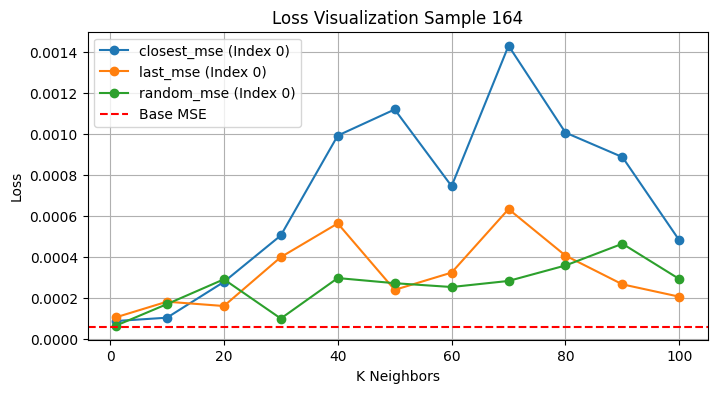

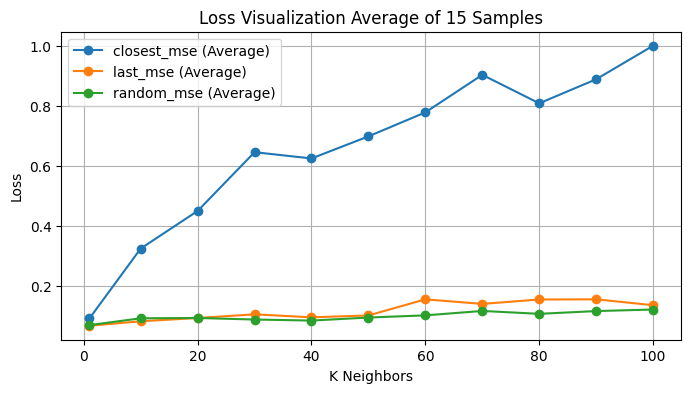

In [19]:
index_base = random_indices[0]
index_pos = random_indices.index(index_base)
predictions_base_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index_base)
base_error = nn.MSELoss()(predictions_base_rgb, sample_targets_rgb)

max_knn = 100  # Set a maximum K value for visualization

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(mse_results, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title=f"Loss Visualization Sample {index_base}", ylabel="Loss", max_knn=max_knn)
visualize_results(mse_results, list_of_indices, average=True, normalize=True, title=f"Loss Visualization Average of {len(random_indices)} Samples", max_knn=max_knn)

1: min=2.59445  max=5.36542  avg=3.94631
10: min=6.37351  max=12.9517  avg=9.01255
20: min=7.41919  max=17.3835  avg=11.3892
30: min=8.07331  max=19.847  avg=13.291
40: min=9.15621  max=22.3139  avg=14.8756
50: min=10.0387  max=23.7333  avg=16.2062
60: min=10.9083  max=25.1384  avg=17.4019
70: min=11.3644  max=26.5262  avg=18.5101
80: min=12.2593  max=27.7954  avg=19.5311
90: min=12.9652  max=29.133  avg=20.444
100: min=13.468  max=30.5924  avg=21.3138


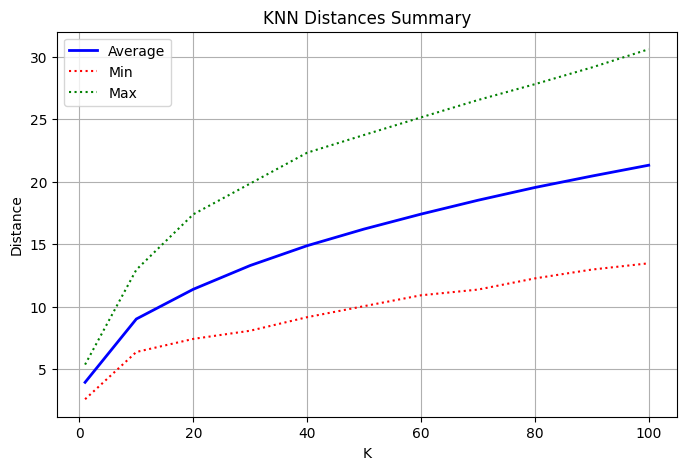

In [20]:
import statistics as stats

closest = knn_distances['closest_distances']  # your dict

def flatten_one_level(x):
    if not x:
        return []
    if isinstance(x[0], (list, tuple)):
        out = []
        for sub in x:
            if isinstance(sub, (list, tuple)):
                out.extend(sub)
            else:
                out.append(sub)
        return out
    return x

summary = {}
for k, v in closest.items():
    vals = flatten_one_level(v)
    if vals:  # skip empty
        summary[k] = {
            "min": min(vals),
            "max": max(vals),
            "avg": stats.fmean(vals),  # numerically robust mean
        }

# Example: print nicely, sorted by key
for k in sorted(summary):
    s = summary[k]
    print(f"{k}: min={s['min']:.6g}  max={s['max']:.6g}  avg={s['avg']:.6g}")
    
# Sort by keys
x = sorted(summary.keys())
y_min = [summary[k]["min"] for k in x]
y_max = [summary[k]["max"] for k in x]
y_avg = [summary[k]["avg"] for k in x]

plt.figure(figsize=(8,5))

# Plot avg as solid line
plt.plot(x, y_avg, label="Average", color="blue", linewidth=2)

# Plot min and max as dotted lines
plt.plot(x, y_min, label="Min", color="red", linestyle="dotted")
plt.plot(x, y_max, label="Max", color="green", linestyle="dotted")

plt.title("KNN Distances Summary")
plt.xlabel("K")
plt.ylabel("Distance")
plt.legend()
plt.grid(True)
plt.show()    